In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from qnetwork.tools import set_plot_style
from scipy.signal import correlate
from experiment_3 import exp003
from experiment_4 import exp004
from experiment_5 import exp005,estimate_frequency_fft,estimate_frequency_L2
from aux_funs import run_ww_simulation

set_plot_style()

# 1. Rabi-like behavior estimation

Because we include many modes, we no longer have a single-mode dynamics, but rather quasi-periodical behavior. for this reason, we need to estimate the 'frequency' of this quasi-oscillations. We have some ways to do this. Namely; 
1. fast fourier transform technique.
2. Minimize $L^{2}$-error technique. 
3. self-correlation technique.

From those, the fastest (and simingly best working) option is number 2. 

## 1.1 Different methods 

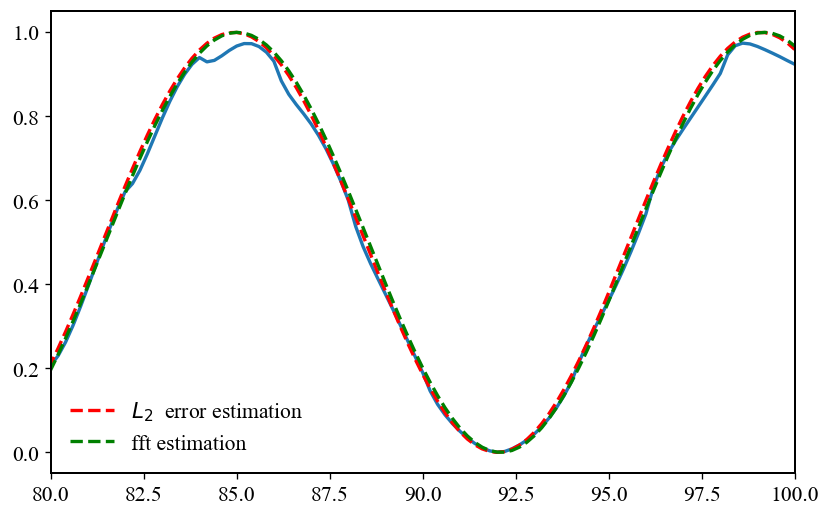

In [2]:
w_L2=estimate_frequency_L2()
w_fft =estimate_frequency_fft()
t,e = run_ww_simulation(t_max=100,n_steps=501)

plt.plot(t,e)
plt.plot(t,np.cos(w_L2*t)**2,'r--',label=r"$L_{2}$  error estimation")
plt.plot(t,np.cos(w_fft*t)**2,'g--',label='fft estimation')
plt.xlim(80,100)
plt.legend()
plt.grid()
plt.show()


## 1.2 Spectral response Vs $\gamma , \Delta $ 

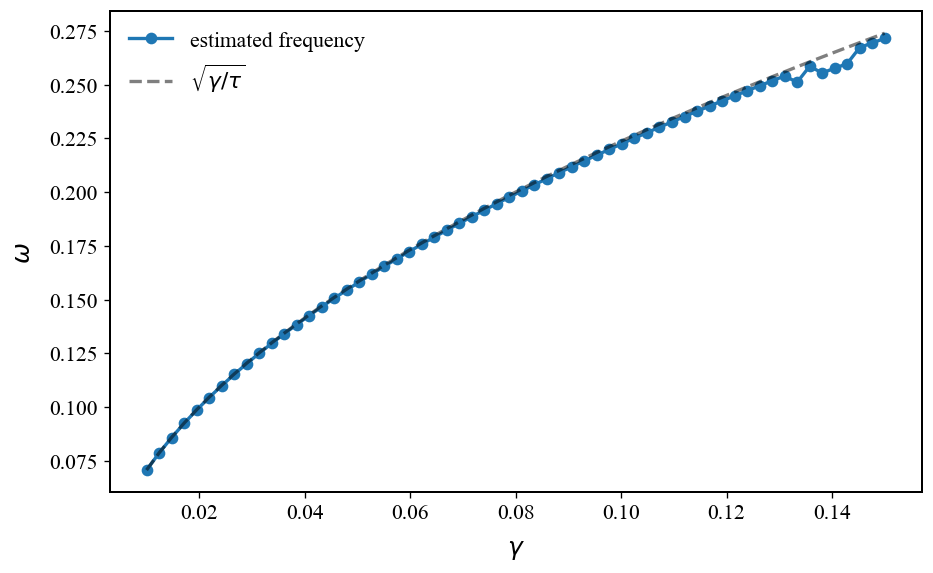

In [11]:
_=exp005(Delta_list=[10],gamma_list=list(np.linspace(0.01,0.15,60)),L2_method='TNC',n_steps=1001,n_modes=70)

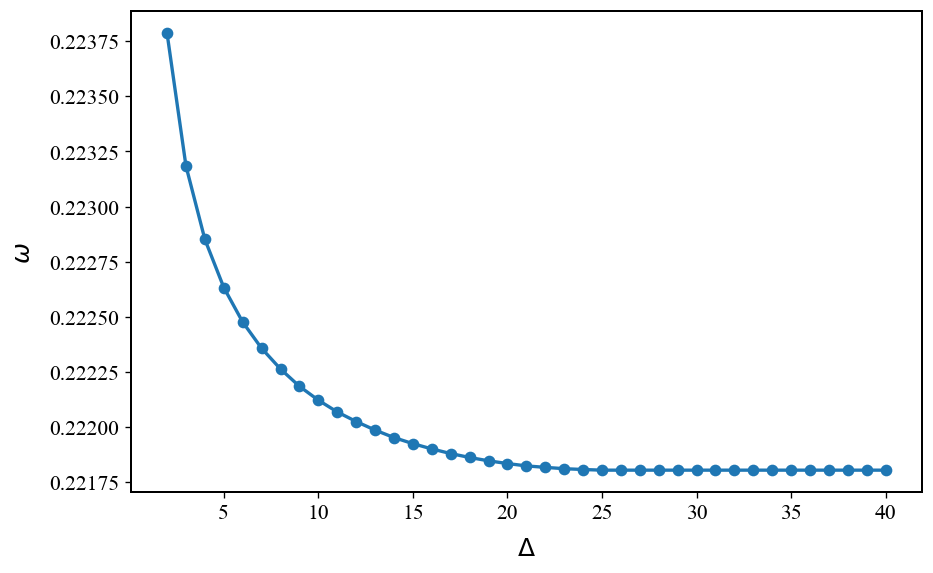

In [6]:
_ = exp005(gamma_list=[0.1],Delta_list=list(range(2,41,1)),n_steps=1001,L2_method='L-BFGS-B')

# Two qubits in a cavity 

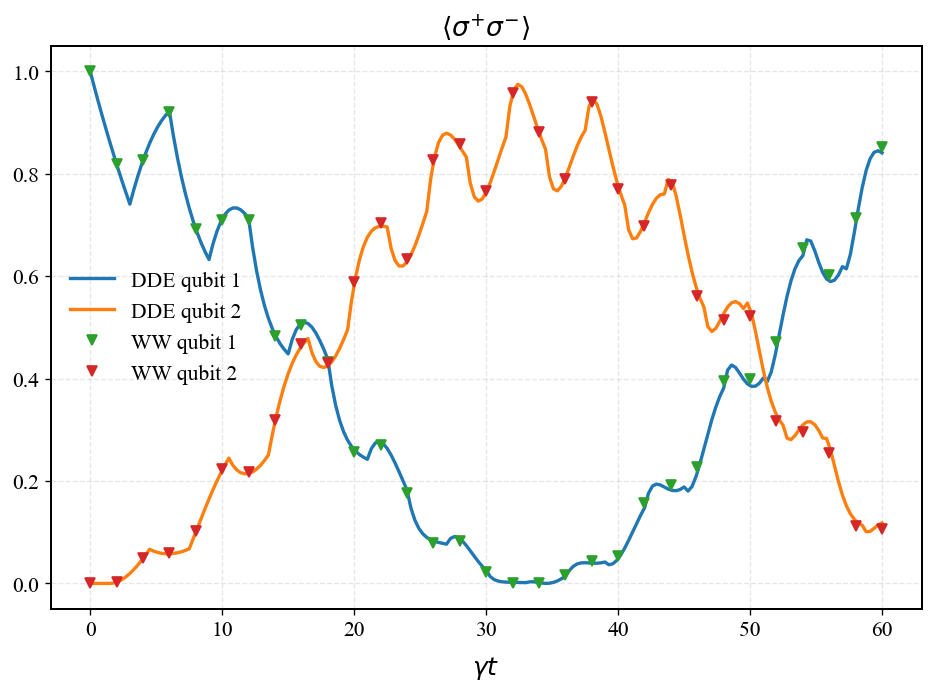

In [53]:
_,_=exp003(phi=100.5*np.pi,n_steps=601,gamma=0.1,L=1.2,c=0.8,t_max=60)

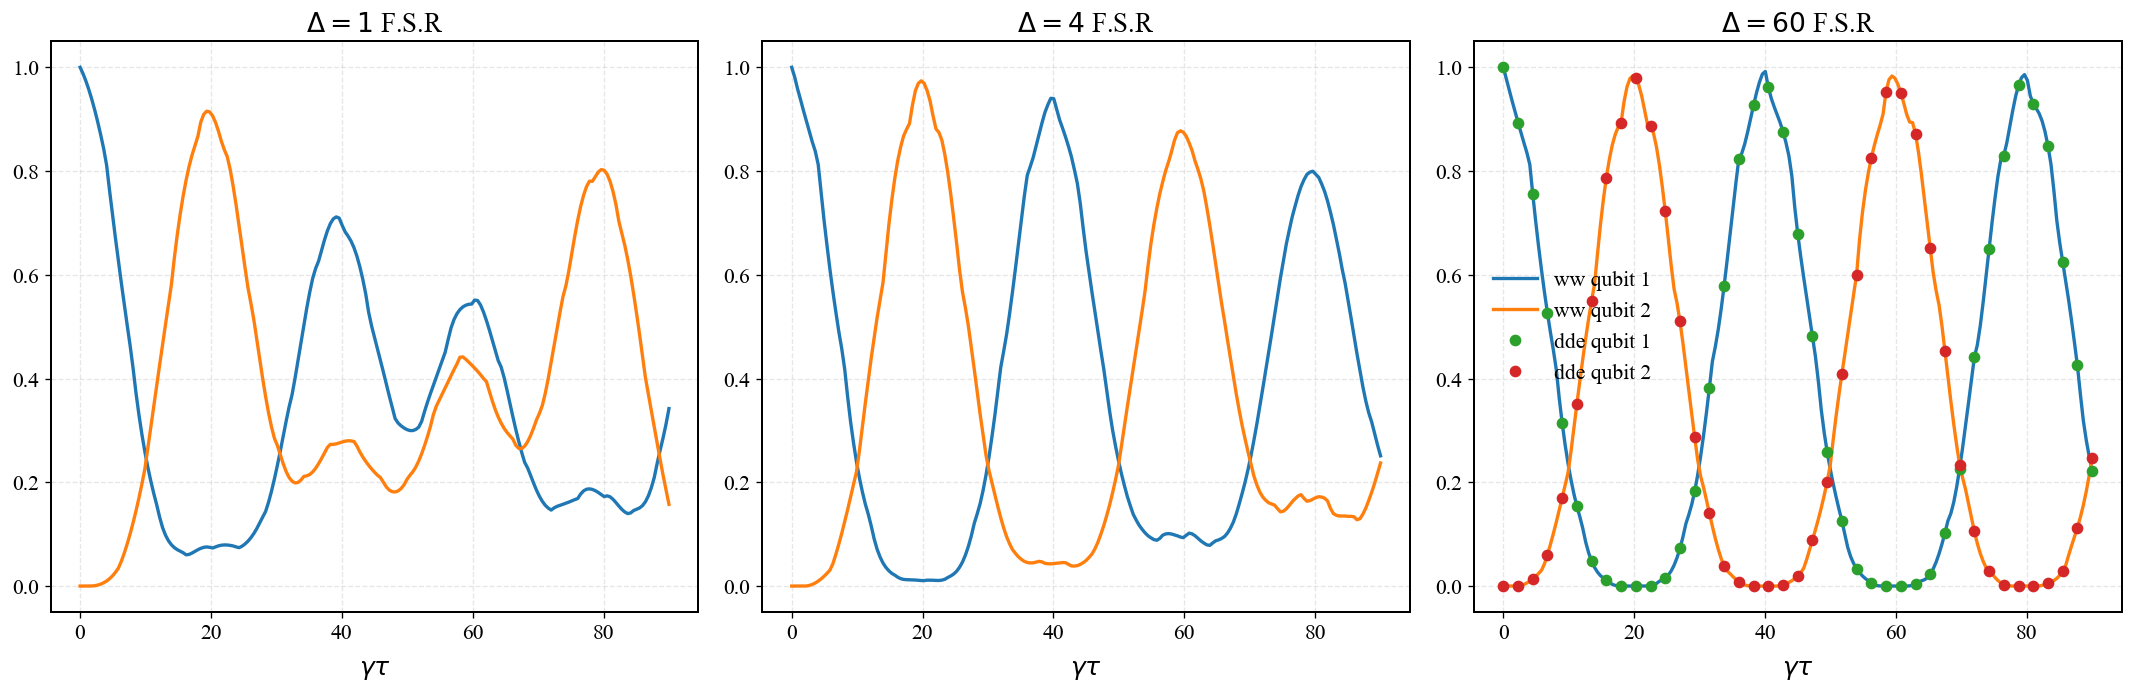

In [54]:
exp004(phi_list=[1*np.pi,4*np.pi,60*np.pi],gamma=0.05,t_max=90)

# Characterization of Rabi-Like behavior 

The points to show in this section are 
1. The DDE contain Rabi physics 
2. The Rabi oscillations are 'protected' by symmetry in high energetic modes of the coupling 

In [ ]:
from scipy.signal import find_peaks
from typing import Optional
from qnetwork.multiphoton_ww import EmittersInWaveguideMultiphotonWW
from aux_funs import DDE_analytical


def run_ww_simulation(t_max: Optional[float] = None , gamma :float = 0.1, Delta: float = 10.0 , L:float = 1, c: float = 1, n_steps: int = 201,n_modes=20):
	tau=2*L/c
	if t_max is None:
		t_max = 25*tau 
	setup=EmittersInWaveguideMultiphotonWW(gamma=gamma,Delta=Delta,L=L,c=c,positions=[0.0], n_modes=n_modes, n_excitations=list(range(2)))
	t,e = setup.evolve(t_max,n_steps=n_steps,initial_state="1")
	return t,e

def run_dde_simulation(t: list|np.ndarray , gamma :float = 0.1, tau: float=2,phi: float = 10.0,):
	return np.abs(DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t))**2



def exp005(t_max: Optional[float] = None , gamma :float = 0.1, Delta: float = 10, L:float = 1, c: float = 1, n_steps: int = 201,plot_bool:bool =True): 

	t = np.linspace(0,t_max,n_steps)
	phi = 2*np.pi*Delta
	tau = 2*L/c
	e_dde = run_dde_simulation(t=t,gamma=gamma,tau=tau,phi=phi)
	e_rabi = np.cos(np.sqrt(gamma/tau)*t)**2

	dt = t[1]-t[0] 
	corr = correlate(e_dde-np.mean(e_dde),e_dde-np.mean(e_dde))
	#corr = correlate(e_dde,e_dde)
	corr_positive = corr[t.shape[0]-1:]
	corr_positive=corr_positive/corr_positive[0]
	peaks_corr,_=find_peaks(corr_positive)
	
	correlation_times=corr_positive[peaks_corr]

	corr_rabi = correlate(e_rabi-np.mean(e_rabi),e_rabi-np.mean(e_rabi))
	#corr_rabi = correlate(e_rabi,e_rabi)
	corr_rabi_positive = corr_rabi[t.shape[0]-1:]
	corr_rabi_positive = corr_rabi_positive/corr_rabi_positive[0]
	peaks_corr_rabi,_=find_peaks(corr_rabi_positive)
	if plot_bool:
		plt.plot(t/tau,corr_positive,label='DDE')
		plt.plot((t/tau)[peaks_corr],correlation_times,'o')
		plt.plot(t/tau,corr_rabi_positive,'r--',label='Rabi')
		plt.plot((t/tau)[peaks_corr_rabi],corr_rabi_positive[peaks_corr_rabi],'o')
		
		plt.axvline(np.pi/np.sqrt(gamma*tau),color='k',linestyle='-.',alpha=0.5,label=r'$\frac{\pi}{\sqrt{\gamma \tau}}$')
		plt.grid()
		plt.legend()
		plt.xlabel(r"$t/\tau$")
		plt.show()
	return t[peaks_corr]

#def exp004(t_max: Optional[float] = None , gamma :float = 0.1, Delta: float = 10, L:float = 1, c: float = 1, n_steps: int = 201,n_modes=20,plot_bool:bool =True): 

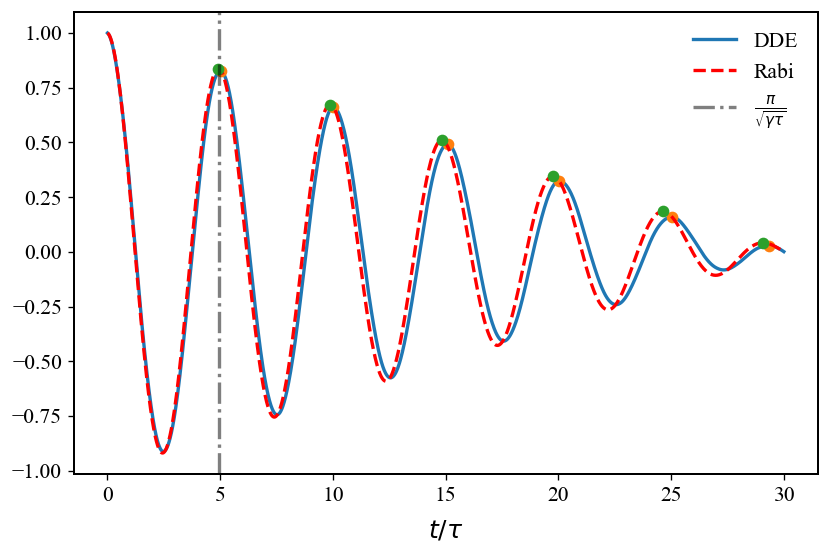

In [68]:
t_corr=exp005(gamma=0.2,t_max=60,n_steps=2501)

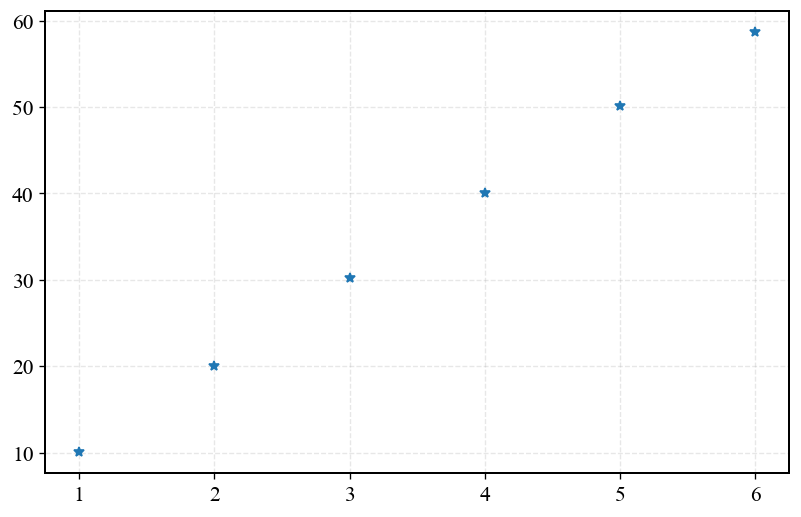

In [70]:
plt.plot(range(1,len(t_corr)+1),t_corr,'*')

In [ ]:
from numpy.fft import fft, fftfreq,fftshift
from aux_funs import paralelizar,run_ww_simulation
from scipy.interpolate import interp1d

def fast_ft(x,y):
	''' regular spacing  is assumed''' 
	N =len(y)
	dt = x[1]-x[0]
	u = fftshift(fft(y-np.mean(y))) 
	w = fftshift(fftfreq(N,dt)) 
	return 2*np.pi*w,u


def estimate_frequency(NT_max:int=30,
		   n_sample: int = 51,
		   gamma:float=0.1,
		   Delta:float=10,
		   L:float=1,
		   c:float=1,
		   n_modes:int=40,
		   n_steps:int=1001,):
	''' Determine an approximated frequency of the dynamics using fast fourier transform techniques + interpolation.
	We estimate the dynamics as [cos(w_fft*t)]**2
	with an initial estimation of the freq es np.sqrt(gamma/tau), we simulate a few periods 
	and change slightly the final time, to explore frequencies around the maximum value. We then keep   '''

	T = 2*np.pi*np.sqrt(2*L/(gamma*c))
	t_max = NT_max*T 

	t_max_list = np.linspace(t_max-T/4,t_max+T/4,n_sample)

	def fft_sample(t_sample):
		t,e= run_ww_simulation(t_max=t_sample,gamma=gamma,Delta=Delta,L=L,c=c,n_modes=n_modes,n_steps=n_steps)
		w,u= fast_ft(t,e) 
		u_m = np.max(np.abs(u))  
		w_m = w[np.argmax(u)]
		return np.abs(w_m),np.abs(u_m) # make the freqs positive. could also be done taking np.real(e) 
	
	data = np.asarray(paralelizar(t_max_list,fft_sample)).T
	x= data[0]
	y = data[1]
	x_interp = np.linspace(np.min(x),np.max(x),1000)
	f = interp1d(x=x,y=y,kind='cubic')
	y_interp = f(x_interp)


	w_fft = x_interp[np.argmax(y_interp)]

	return 0.5*w_fft
	


In [199]:
gamma=0.078
Delta=12
L=1
c=1
tau=2*L/c

t,e = run_ww_simulation(gamma=gamma,Delta=Delta,t_max=60)

w_ref=np.sqrt(gamma/tau)
w_fft=estimate_frequency(gamma=gamma,Delta=Delta)



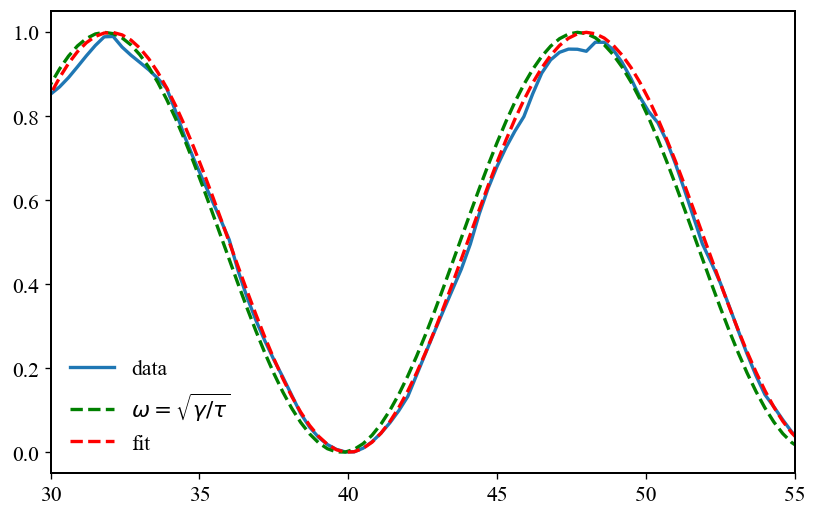

In [201]:
plt.plot(t,e,label='data')
plt.plot(t,np.cos(w_ref*t)**2,'g--',label=r'$\omega = \sqrt{\gamma/\tau}$')
plt.plot(t,np.cos(w_fft*t)**2,'r--',label='fit')

plt.xlim(30,55)
plt.legend()
plt.grid()
plt.show()

In [254]:
from scipy.optimize import minimize

def L2_error(x,y,y_ref): 
	dif = np.abs(y_ref-y)
	
	return  np.abs(np.trapezoid(y=np.sqrt(dif**2),x=x)/ np.trapezoid(y=np.abs(y),x=x))

def estimate_frequency_2(gamma:float=0.1,
						Delta:float = 12,
						L:float=1,
						c:float=1,
						n_modes:int=40,
						n_steps:int=1001):
	''' Also estimating the frequency, but now minimizing the L2 error with a scipy tool.  '''

	T = 2*np.pi*np.sqrt(2*L/(gamma*c))
	t_max = 30*T
	
	t,e = run_ww_simulation(t_max=t_max,gamma=gamma,Delta=Delta,n_modes=n_modes,n_steps=n_steps,L=L,c=c)
	
	def sample_function(freq):
		y = np.cos(freq*t)**2
		return L2_error(t,y,e)
	
	w = minimize(fun=sample_function,x0=np.sqrt(gamma/(2*L/c)),method='TNC')
	print('estimated frequency: '+str(np.round(w.x,5)))
	return w.x
		
	

In [257]:
w_L2=estimate_frequency_2()
w_fft =estimate_frequency()
	


estimated frequency: [0.22194]


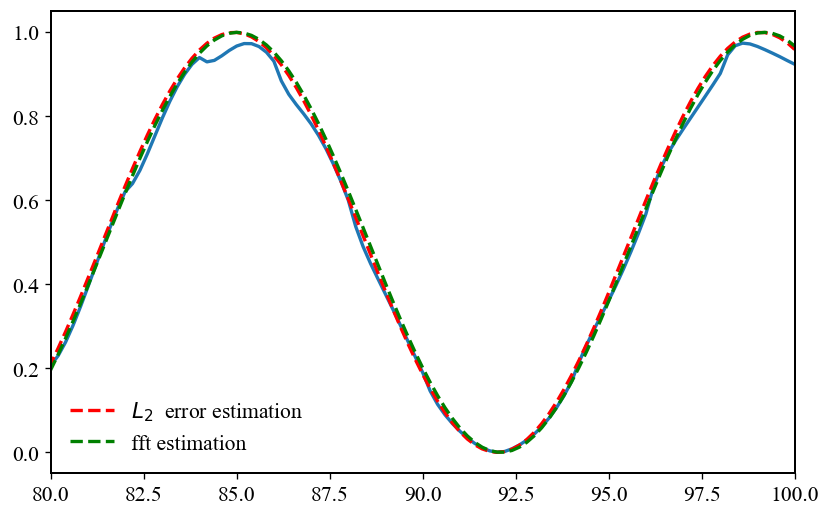

In [260]:
t,e = run_ww_simulation(t_max=100,n_steps=501)

plt.plot(t,e)
plt.plot(t,np.cos(w_L2*t)**2,'r--',label=r"$L_{2}$  error estimation")
plt.plot(t,np.cos(w_fft*t)**2,'g--',label='fft estimation')
plt.xlim(80,100)
plt.legend()
plt.grid()
plt.show()

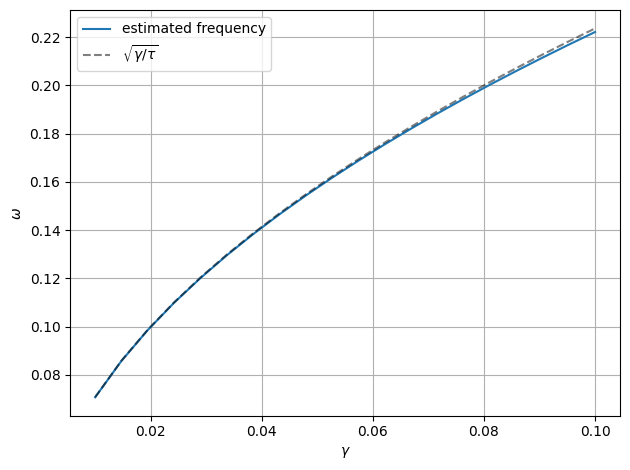

In [ ]:
from experiment_5 import exp005

